In [7]:
# ## 1. Get PD

In [22]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
import time
import requests
import yaml
import random

In [72]:
START_TIME = time.time()
LIMIT_DATASET = False

LOOK_AHEAD = 5  # Mins
EXPERIMENT_RUNS = 1

# WEIGHTS --> [cost, over_provision, overhead, support_deviation, same_version]
WEIGHTS = {
    "negative": {
        "cost": 5,
        "over_provision": 5,
        "overhead": 1
    },
    "positive": {
        "support_deviation": 1,
        "same_version": 1,
        "support_max": 0,
        "support_recent_history": 0
    }
}

accuracy_list = [1.0]
# accuracy_list = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]

In [73]:
r = requests.get(
    'https://raw.githubusercontent.com/CN-UPB/Pishahang/mvp-thesis/pish-examples/pwm-scripts/descriptors/multiversion/transcoder_mv_policy.yml')
# print(r.text)
PD = yaml.load(r.text, Loader=yaml.FullLoader)


# PD["versions"] = {
#     'virtual_deployment_units_gpu': {'transcoder-image-1-gpu': {'cost_per_min': 0.0087,
#                                                                 'max_data_rate': 3000,
#                                                                 'management_overhead': 6}},
#     'virtual_deployment_units_con': {'transcoder-image-1-con': {'cost_per_min': 0.0007,
#                                                                 'max_data_rate': 1200,
#                                                                 'management_overhead': 6}}}

VM_COST_PER_MINUTE = PD["versions"]['virtual_deployment_units_vm']["transcoder-image-1-vm"]['cost_per_min']
CON_COST_PER_MINUTE = PD["versions"]['virtual_deployment_units_con']["transcoder-image-1-con"]['cost_per_min']
GPU_COST_PER_MINUTE = PD["versions"]['virtual_deployment_units_gpu']["transcoder-image-1-gpu"]['cost_per_min']

# for _vm_type_key, _vm_type_value in PD["versions"].items():
#     print(_vm_type_key)
#     for _vm_version_key, _vm_version_value in _vm_type_value.items():
#         print(_vm_version_key)
#         print(_vm_version_value)
#         print("\n")

In [74]:

_SCORE_MIN, _SCORE_MAX = 1, 5

'''
Find the version with the max supported datarate
'''


def find_max_datarate_version(versions):
    _max_datarate = 0

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])

            if _vm_version_value["max_data_rate"] > _max_datarate:
                _max_datarate = _vm_version_value["max_data_rate"]
                _max_datarate_version = {_vm_type_key: {
                    _vm_version_key: _vm_version_value}}

    return _max_datarate_version


'''
Get all the versions that can support the datarate demand
'''


def get_supported_versions(prediction, versions):
    # Iterate versions
    datarate_supported_versions = {}

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])
            # print(prediction["mean"])
            if _vm_version_value["max_data_rate"] >= prediction["mean"]:
                # check if key present else add
                if _vm_type_key in datarate_supported_versions:
                    datarate_supported_versions[_vm_type_key][_vm_version_key] = _vm_version_value
                else:
                    datarate_supported_versions[_vm_type_key] = {}
                    datarate_supported_versions[_vm_type_key][_vm_version_key] = _vm_version_value

    if len(datarate_supported_versions) == 0:
        return find_max_datarate_version(versions)
    return datarate_supported_versions


'''
Interpolate data points to a certain range
'''


def interpolate_array(values, min=_SCORE_MIN, max=_SCORE_MAX):
    return np.interp(values, (values.min(), values.max()), (min, max))


'''
Build the decision matrix for a given traffic prediction values 
'''


def build_decision_matrix(prediction, meta, versions):
    _decision_matrix = {}
    for _vm_type_key, _vm_type_value in versions.items():
        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            if _vm_type_key not in _decision_matrix:
                _decision_matrix[_vm_type_key] = {}
            if _vm_version_key not in _decision_matrix[_vm_type_key]:
                _decision_matrix[_vm_type_key][_vm_version_key] = {}

            # Cost
            _decision_matrix[_vm_type_key][_vm_version_key]["cost"] = _vm_version_value['cost_per_min']

            # Support deviation
            if _vm_version_value['max_data_rate'] > (prediction['mean'] + prediction['std']):
                _decision_matrix[_vm_type_key][_vm_version_key]["support_deviation"] = 5
            else:
                _decision_matrix[_vm_type_key][_vm_version_key]["support_deviation"] = 1

            # Over Provision
            _decision_matrix[_vm_type_key][_vm_version_key]["over_provision"] = int(
                _vm_version_value['max_data_rate']) - int(prediction['mean'])

            # Same Version
            if meta["current_version"] == _vm_version_key:
                _decision_matrix[_vm_type_key][_vm_version_key]["same_version"] = 5
            else:
                _decision_matrix[_vm_type_key][_vm_version_key]["same_version"] = 1

            # Overhead
            _decision_matrix[_vm_type_key][_vm_version_key]["overhead"] = _vm_version_value['management_overhead']

            # Support max datarate
            if _vm_version_value['max_data_rate'] >= (prediction['max']):
                _decision_matrix[_vm_type_key][_vm_version_key]["support_max"] = 5
            else:
                _decision_matrix[_vm_type_key][_vm_version_key]["support_max"] = 1

            # Support recent history
            if _vm_version_value['max_data_rate'] >= (meta["recent_history"]["mean"]):
                _decision_matrix[_vm_type_key][_vm_version_key]["support_recent_history"] = 5
            else:
                _decision_matrix[_vm_type_key][_vm_version_key]["support_recent_history"] = 1

    decision_matrix_df = pd.DataFrame.from_dict({(i, j): _decision_matrix[i][j]
                                                 for i in _decision_matrix.keys()
                                                 for j in _decision_matrix[i].keys()},
                                                orient='index')

    decision_matrix_df["over_provision"] = interpolate_array(
        decision_matrix_df["over_provision"])
    decision_matrix_df["cost"] = interpolate_array(decision_matrix_df["cost"])
    decision_matrix_df["overhead"] = interpolate_array(
        decision_matrix_df["overhead"])

    return decision_matrix_df


'''
Get policy decision given decision matrix and weights
'''


def get_policy_decision(decision_matrix, weights):

    # Negative
    cost = -1 * weights["negative"]["cost"]
    over_provision = -1 * weights["negative"]["over_provision"]
    overhead = -1 * weights["negative"]["overhead"]

    # Positive
    support_deviation = weights["positive"]['support_deviation']
    same_version = weights["positive"]['same_version']

    # WEIGHTS --> [cost, over_provision, overhead, support_deviation, same_version]
    weights_row = [cost, over_provision,
                   overhead, support_deviation, same_version]

    for index_label, row_series in decision_matrix.iterrows():
        _row = np.array([row_series.cost, row_series.over_provision, row_series.overhead,
                         row_series.support_deviation, row_series.same_version])

        decision_matrix.at[index_label, 'score'] = np.dot(
            np.array(weights_row), _row)

    _version = decision_matrix[decision_matrix.score ==
                               decision_matrix.score.max()].index[0]
    return _version


'''
Find the version with least cost
'''


def find_cheapest_version(versions):
    _cost = None

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])
            # FIXME: cost_per_min should be int
            if _cost is None:
                _cost = _vm_version_value["cost_per_min"]
                _cost_version = (_vm_type_key, _vm_version_key)

            if float(_vm_version_value["cost_per_min"]) < float(_cost):
                _cost = _vm_version_value["cost_per_min"]
                # _cost_version = { _vm_type_key: { _vm_version_key : _vm_version_value } }
                _cost_version = (_vm_type_key, _vm_version_key)

    return _cost_version


def get_switch_qos_metrics(current_version, previous_version):
    qos_metrics = {}
    if "vm" in previous_version:
        if "vm" in current_version:
            # qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 0
            qos_metrics['buffertime'] = 0
            qos_metrics['switchtime'] = 0
        if "con" in current_version:
            # qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5
        if "gpu" in current_version:
            # qos_metrics['datarate'] = 5275
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5

    if "con" in previous_version:
        if "con" in current_version:
            # qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 0
            qos_metrics['buffertime'] = 0
            qos_metrics['switchtime'] = 0
        if "vm" in current_version:
            # qos_metrics['datarate'] = 668
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 85
        if "gpu" in current_version:
            # qos_metrics['datarate'] = 5415
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5

    if "gpu" in previous_version:
        if "gpu" in current_version:
            # qos_metrics['datarate'] = 5800
            qos_metrics['downtime'] = 0
            qos_metrics['buffertime'] = 0
            qos_metrics['switchtime'] = 0
        if "vm" in current_version:
            # qos_metrics['datarate'] = 2020
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 85
        if "con" in current_version:
            # qos_metrics['datarate'] = 825
            qos_metrics['downtime'] = 3
            qos_metrics['buffertime'] = 3
            qos_metrics['switchtime'] = 5

    return qos_metrics


def get_binomial_samples(size, n=1, p=0.9):
    return np.random.binomial(n, p, size)


def get_prob_new_datarate(datarate, p=0.5, accuracy=0.9):
    delta = (1.0 - accuracy) * datarate

    if random.random() < p:
        new_datarate = datarate + delta
    else:
        new_datarate = datarate - delta

    return new_datarate


# -

# # Run Policy on Dataset
# ---
#

In [75]:


traffic_training_complete = pd.read_csv(
    r'/plugins/son-mano-traffic-forecast/notebooks/data/dataset_six_traffic.csv', index_col=0)

if LIMIT_DATASET:
    traffic_training_complete = traffic_training_complete[:LIMIT_DATASET]

print(traffic_training_complete.shape)
traffic_training_complete.head(5)
# -

(11000, 1)


,sent
2020-04-29 06:02:00,1316.078802
2020-04-29 06:03:00,1313.641835
2020-04-29 06:04:00,1311.856471
2020-04-29 06:05:00,1331.206319
2020-04-29 06:06:00,1334.096847


In [76]:
##################################
# Functions for experiment runner
##################################


def get_decision_dataset(traffic_grouped, traffic_history):
    switch_counter = {"pc_{}".format(
        int(_acc*100)): 0 for _acc in accuracy_list}
    switch_counter['history'] = 0
    _results = {}

    # Run Policy on Dataset
    for _acc in accuracy_list:
        _acc_pc = "pc_{}".format(int(_acc*100))
        _results[_acc_pc] = traffic_grouped[_acc_pc].copy()
        # traffic_policy_test.plot()

        # iterate over the dataframe row by row and set version
        meta = {
            "current_version": "transcoder-image-1-vm",
            "current_version_history": "transcoder-image-1-vm",
            "recent_history": None
        }

        with open("output_debug.log", "w") as f:
            for index_label, row_series in _results[_acc_pc].iterrows():
                if meta["recent_history"] is None:
                    meta["recent_history"] = row_series

                supported_versions = get_supported_versions(
                    prediction=row_series, versions=PD["versions"])

                decision_matrix_df = build_decision_matrix(
                    prediction=row_series, meta=meta, versions=supported_versions)

                _selected_version = ":".join(
                    get_policy_decision(decision_matrix_df, WEIGHTS))
                _results[_acc_pc].at[index_label, 'policy'] = _selected_version

                if not _selected_version.split(":")[1] == meta["current_version"]:
                    switch_counter[_acc_pc] += 1

                f.write("\nrecent_history\n")
                f.write(str(meta["recent_history"]))
                f.write("\nForecast\n")
                f.write(str(row_series))

                meta = {
                    "current_version": _selected_version.split(":")[1],
                    "recent_history": row_series
                }

                f.write("\n\n_selected_version\n")
                f.write(_selected_version)
                f.write("\n\n")
                f.write(str(decision_matrix_df))
                f.write("\n\n")

    # Run for History
    meta = {
        "current_version_history": "transcoder-image-1-vm",
        "recent_history": None
    }

    row_counter = 0

    for index_label, row_series in traffic_history.iterrows():
        if meta["recent_history"] is None:
            meta["recent_history"] = row_series['sent']

        # print(row_series)

        supported_versions_history = get_supported_versions(
            prediction={"mean": meta['recent_history']}, versions=PD["versions"])

        _selected_version_history = ":".join(
            find_cheapest_version(versions=supported_versions_history))
        traffic_history.at[index_label, 'history'] = _selected_version_history

        if not _selected_version_history.split(":")[1] == meta["current_version_history"]:
            switch_counter["history"] += 1

        meta = {
            "current_version_history": _selected_version_history.split(":")[1],
            "recent_history": row_series['sent']
        }

        row_counter += 1

    # Merge Data
    final_decision_dataset = pd.DataFrame()
    for _acc in accuracy_list:
        _acc_pc = "pc_{}".format(int(_acc*100))

        final_decision_dataset[_acc_pc] = _results[_acc_pc].iloc[np.repeat(np.arange(
            len(_results[_acc_pc])), 5)].reset_index().drop('index', axis=1)['policy']

        # print("\npc_{}".format(int(_acc*100)))
        # print(final_decision_dataset[_acc_pc].value_counts())

    final_decision_dataset['history'] = traffic_history['history']

    return {
        "switch_counter": switch_counter,
        "final_decision_dataset": final_decision_dataset
    }


def get_qos_dataset(final_decision_dataset):
    qos_final_decision_dataset = pd.DataFrame()

    qos_results = {}

    for _acc in accuracy_list:
        _acc_pc = "pc_{}".format(int(_acc*100))
        _previous_version = None
        _current_version = None

        qos_results[_acc_pc] = {
            # 'datarate': [],
            'downtime': [],
            'buffertime': [],
            'switchtime': [],
            'wrongversion': [],
            'under_utilized': [],
            'over_loaded': []
        }

        for index_label, row_series in final_decision_dataset.iterrows():
            if _previous_version == None:
                _previous_version = row_series[_acc_pc]

            _current_version = row_series[_acc_pc]
            _proper_version = row_series['pc_100']

            qos_metrics = get_switch_qos_metrics(
                _current_version, _previous_version)

            if _proper_version != _current_version:
                # print(_proper_version, _current_version, _acc_pc)
                qos_metrics['wrongversion'] = 1
                qos_metrics['under_utilized'] = 0
                qos_metrics['over_loaded'] = 0

                if "gpu" in _proper_version:
                    # VNF is overloaded
                    qos_metrics['over_loaded'] = 1
                if "vm" in _proper_version:
                    if "gpu" in _current_version:
                        qos_metrics['under_utilized'] = 1
                if "con" in _proper_version:
                    if "gpu" in _current_version:
                        qos_metrics['under_utilized'] = 1
            else:
                qos_metrics['wrongversion'] = 0
                qos_metrics['under_utilized'] = 0
                qos_metrics['over_loaded'] = 0

            for _k in qos_metrics.keys():
                qos_results[_acc_pc][_k].append(qos_metrics[_k])

            _previous_version = _current_version

    # For History
    _previous_version = None
    _current_version = None
    _acc_pc = "history"

    qos_results[_acc_pc] = {
        # 'datarate': [],
        'downtime': [],
        'buffertime': [],
        'switchtime': [],
        'wrongversion': [],
        'under_utilized': [],
        'over_loaded': []
    }

    for index_label, row_series in final_decision_dataset.iterrows():
        if _previous_version == None:
            _previous_version = row_series[_acc_pc]

        _current_version = row_series[_acc_pc]
        _proper_version = row_series['pc_100']

        qos_metrics = get_switch_qos_metrics(
            _current_version, _previous_version)

        if _proper_version != _current_version:
            # print(_proper_version, _current_version, _acc_pc)
            qos_metrics['wrongversion'] = 1
            qos_metrics['under_utilized'] = 0
            qos_metrics['over_loaded'] = 0

            if "gpu" in _proper_version:
                # VNF is overloaded
                qos_metrics['over_loaded'] = 1
            if "vm" in _proper_version:
                if "gpu" in _current_version:
                    qos_metrics['under_utilized'] = 1
            if "con" in _proper_version:
                if "gpu" in _current_version:
                    qos_metrics['under_utilized'] = 1
        else:
            qos_metrics['wrongversion'] = 0
            qos_metrics['under_utilized'] = 0
            qos_metrics['over_loaded'] = 0

        for _k in qos_metrics.keys():
            qos_results[_acc_pc][_k].append(qos_metrics[_k])

        _previous_version = _current_version
    qos_final_decision_dataset = pd.DataFrame.from_dict({(i, j): qos_results[i][j]
                                                         for i in qos_results.keys()
                                                         for j in qos_results[i].keys()})

    return {
        "qos_final_decision_dataset": qos_final_decision_dataset,
        "qos_final_decision_dataset_sum": qos_final_decision_dataset.sum()
    }


def get_total_price(final_decision_dataset):
    _type = []
    _prices = []

    _result = {}

    skip_history = False
    for _acc in accuracy_list:
        _acc_pc = "pc_{}".format(int(_acc*100))
        _acc_price = 0
        _value_counts = final_decision_dataset[_acc_pc].value_counts()

        for k, v in _value_counts.iteritems():
            if "gpu" in k:
                _acc_price += (GPU_COST_PER_MINUTE * LOOK_AHEAD * v)
            if "vm" in k:
                _acc_price += (VM_COST_PER_MINUTE * LOOK_AHEAD * v)
            if "con" in k:
                _acc_price += (CON_COST_PER_MINUTE * LOOK_AHEAD * v)

        if _acc_pc not in _result.keys():
            _result[_acc_pc] = _acc_price

    _acc_pc = "history"
    _acc_price = 0

    _value_counts = final_decision_dataset[_acc_pc].value_counts()

    for k, v in _value_counts.iteritems():
        # print(k, v)
        if "gpu" in k:
            _acc_price += (GPU_COST_PER_MINUTE * LOOK_AHEAD * v)
        if "vm" in k:
            _acc_price += (VM_COST_PER_MINUTE * LOOK_AHEAD * v)
        if "con" in k:
            _acc_price += (CON_COST_PER_MINUTE * LOOK_AHEAD * v)

    if _acc_pc not in _result.keys():
        _result[_acc_pc] = _acc_price

    return(_result)
# ## Random errors to get different accuracies

In [77]:

# http://patorjk.com/software/taag/#p=display&f=ANSI%20Regular&t=Run%20EXP

#####################################################
#####################################################
#
# ██████  ██    ██ ███    ██     ███████ ██   ██ ██████
# ██   ██ ██    ██ ████   ██     ██       ██ ██  ██   ██ 
# ██████  ██    ██ ██ ██  ██     █████     ███   ██████  
# ██   ██ ██    ██ ██  ██ ██     ██       ██ ██  ██
# ██   ██  ██████  ██   ████     ███████ ██   ██ ██
#
#####################################################
#####################################################


_run_results = {
    "switch_counter": [],
    "qos_sum": [],
    "prices": []
}

for _run in range(EXPERIMENT_RUNS):
    print("RUN: ", _run)
    # Generate different probabalistic datasets
    for _acc in accuracy_list:
        _acc_pc = "pc_{}".format(int(_acc*100))

        _acc_samples = get_binomial_samples(
            size=traffic_training_complete.shape[0], n=1, p=_acc)

        traffic_training_complete[_acc_pc] = np.where(_acc_samples,
                                                      traffic_training_complete['sent'],
                                                      get_prob_new_datarate(traffic_training_complete['sent'], accuracy=_acc))

    # Group data according to look ahead
    traffic_grouped = traffic_training_complete.groupby(
        np.arange(len(traffic_training_complete))//LOOK_AHEAD).agg(['mean', 'std', 'min', 'max'])

    traffic_history = traffic_training_complete.reset_index().copy().drop('index', axis=1)

# Get decision dataset
    decision_results = get_decision_dataset(traffic_grouped, traffic_history)

    _run_results["switch_counter"].append(decision_results["switch_counter"])

# Get QoS results
    qos_results = get_qos_dataset(decision_results["final_decision_dataset"])
    _run_results["qos_sum"].append(
        qos_results["qos_final_decision_dataset_sum"])

# Get Prices
    price_result = get_total_price(decision_results["final_decision_dataset"])
    _run_results["prices"].append(
        price_result)

# final_decision_dataset.to_csv('./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD))
# print(final_decision_dataset.shape)
# final_decision_dataset.head(10)

switch_counter_df = pd.DataFrame.from_records(_run_results["switch_counter"])
qos_sum_df = pd.DataFrame.from_records(_run_results["qos_sum"])
prices_df = pd.DataFrame.from_records(_run_results["prices"])

switch_counter_df.to_csv(
    './data/{}_runs_experiment_switch_counter_df.csv'.format(EXPERIMENT_RUNS))
qos_sum_df.to_csv(
    './data/{}_runs_experiment_qos_sum_df.csv'.format(EXPERIMENT_RUNS))
prices_df.to_csv(
    './data/{}_runs_experiment_prices_df.csv'.format(EXPERIMENT_RUNS))


switch_counter_df.head()
qos_sum_df.head()
prices_df.head()

RUN:  0


,pc_100,history
0,224.5,221.106


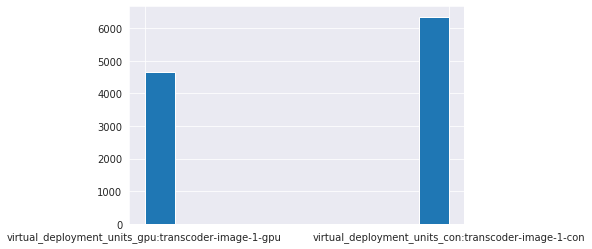

In [86]:
# Decision Histogram
decision_results["final_decision_dataset"]['pc_100'].hist()
# decision_results["final_decision_dataset"]['history'].hist()

In [79]:

#####################################################
#####################################################
#
# ██████  ███████ ███████ ██    ██ ██   ████████ ███████ 
# ██   ██ ██      ██      ██    ██ ██      ██    ██      
# ██████  █████   ███████ ██    ██ ██      ██    ███████ 
# ██   ██ ██           ██ ██    ██ ██      ██         ██ 
# ██   ██ ███████ ███████  ██████  ███████ ██    ███████ 
#
#####################################################
#####################################################

switch_counter_df_complete = pd.read_csv(
    './data/{}_runs_experiment_switch_counter_df.csv'.format(EXPERIMENT_RUNS), index_col=0)
qos_sum_df_complete = pd.read_csv(
    './data/{}_runs_experiment_qos_sum_df.csv'.format(EXPERIMENT_RUNS), index_col=0, header=[0, 1])
prices_df_complete = pd.read_csv(
    './data/{}_runs_experiment_prices_df.csv'.format(EXPERIMENT_RUNS), index_col=0)

# switch_counter_df = switch_counter_df_complete.agg(
#     ['mean', 'std', 'min', 'max', 'median']).transpose()
# qos_sum_df = qos_sum_df_complete.agg(
#     ['mean', 'std', 'min', 'max', 'median']).transpose()

# boxplot = qos_sum_df_complete.boxplot( figsize=(10,5))

# b = qos_sum_df_complete.stack(level=0).reset_index(level=0, drop=True).reset_index().boxplot(by='index', column=["buffertime","downtime"], figsize=(10,10))

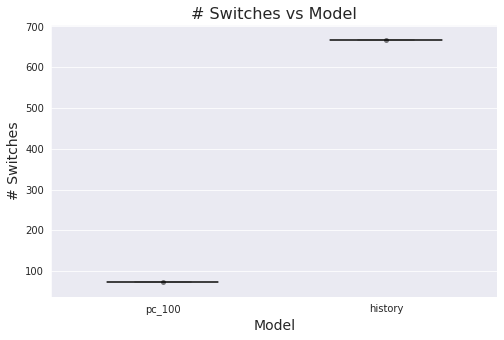

In [80]:

#############################################
#############################################
# 1. Switches (Box Plot)
#############################################
#############################################

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))

# make boxplot with Seaborn
bplot = sns.boxplot(
    data=switch_counter_df_complete,
    width=0.5,
    palette="colorblind"
)

# add stripplot to boxplot with Seaborn
bplot = sns.stripplot(
    data=switch_counter_df_complete,
    jitter=False,
    marker='o',
    alpha=0.5,
    color='black')

bplot.axes.set_title("# Switches vs Model",
                     fontsize=16)

bplot.set_xlabel("Model",
                 fontsize=14)

bplot.set_ylabel("# Switches",
                 fontsize=14)

bplot.tick_params(labelsize=10)

# output file name
plot_file_name = "./results/1_no_switches.png"

# save as jpeg
bplot.figure.savefig(plot_file_name,
                     format='png',
                     dpi=300)

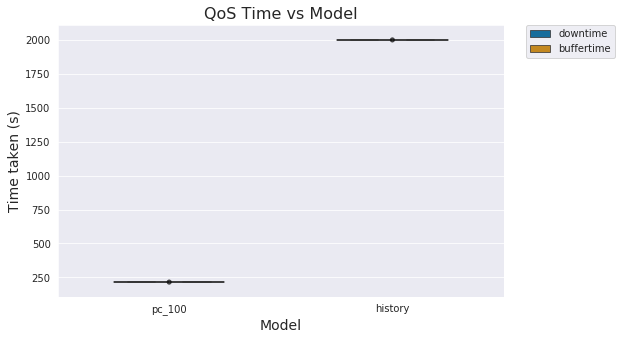

In [81]:

#############################################
#############################################
# 2a. QoS Times (Box Plot)
#############################################
#############################################

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))

# qos_sum_df_complete.xs('downtime', axis=1, level=1, drop_level=False)

# qos_sum_df_complete.xs('downtime', axis=1, level=1).boxplot(figsize=(10, 5))

qos_sum_df_unstacked = qos_sum_df_complete.unstack(
    level=0).reset_index(level=2, drop=True).reset_index(name='data')

qos_times = qos_sum_df_unstacked[qos_sum_df_unstacked["level_1"].isin(
    ['downtime', 'buffertime'])]

switch_times = qos_sum_df_unstacked[qos_sum_df_unstacked["level_1"].isin([
                                                                         'switchtime'])]


bplot = sns.boxplot(
    x='level_0',
    y='data',
    hue="level_1",
    data=qos_times,
    width=0.5,
    palette="colorblind")

# add stripplot to boxplot with Seaborn
bplot = sns.stripplot(
    x='level_0',
    y='data',
    hue="level_1",
    data=qos_times,
    jitter=False,
    marker='o',
    alpha=0.5,
    color='black')

handles, labels = bplot.get_legend_handles_labels()

_HANDLES = 2
l = plt.legend(handles[0:_HANDLES], labels[0:_HANDLES],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

bplot.axes.set_title("QoS Time vs Model",
                     fontsize=16)

bplot.set_xlabel("Model",
                 fontsize=14)

bplot.set_ylabel("Time taken (s)",
                 fontsize=14)

bplot.tick_params(labelsize=10)

# output file name
plot_file_name = "./results/2a_qos_times.png"

# save as jpeg
bplot.figure.savefig(plot_file_name,
                     format='png',
                     dpi=300)

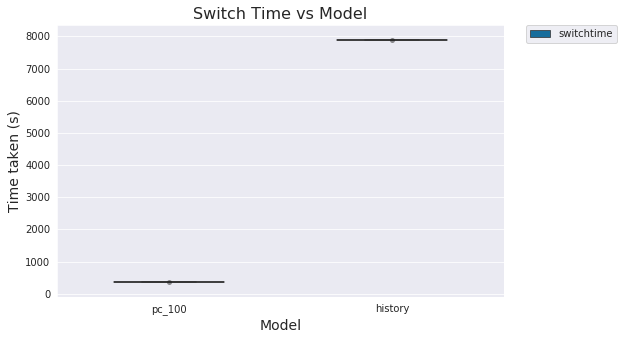

In [82]:

#############################################
#############################################
# 2b. Switch Time  (Box Plot)
#############################################
#############################################

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))

qos_sum_df_unstacked = qos_sum_df_complete.unstack(
    level=0).reset_index(level=2, drop=True).reset_index(name='data')

switch_times = qos_sum_df_unstacked[qos_sum_df_unstacked["level_1"].isin([
                                                                         'switchtime'])]


bplot = sns.boxplot(
    x='level_0',
    y='data',
    hue="level_1",
    data=switch_times,
    width=0.5,
    palette="colorblind")

# add stripplot to boxplot with Seaborn
bplot = sns.stripplot(
    x='level_0',
    y='data',
    hue="level_1",
    data=switch_times,
    jitter=False,
    marker='o',
    alpha=0.5,
    color='black')

handles, labels = bplot.get_legend_handles_labels()

_HANDLES = 1
l = plt.legend(handles[0:_HANDLES], labels[0:_HANDLES],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

bplot.axes.set_title("Switch Time vs Model",
                     fontsize=16)

bplot.set_xlabel("Model",
                 fontsize=14)

bplot.set_ylabel("Time taken (s)",
                 fontsize=14)

bplot.tick_params(labelsize=10)

# output file name
plot_file_name = "./results/2b_switch_times.png"

# save as jpeg
bplot.figure.savefig(plot_file_name,
                     format='png',
                     dpi=300)

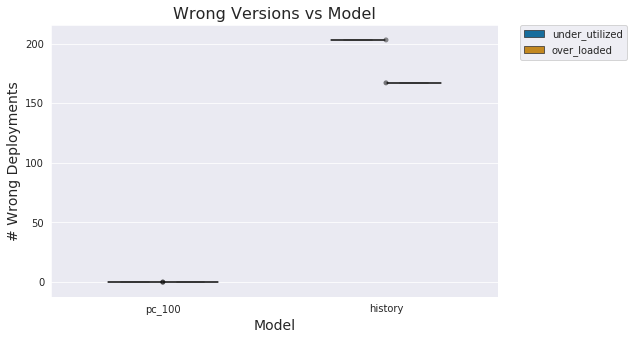

In [83]:

#############################################
#############################################
# 2c. Wrong Versions (Box Plot)
#############################################
#############################################

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))

qos_sum_df_unstacked = qos_sum_df_complete.unstack(
    level=0).reset_index(level=2, drop=True).reset_index(name='data')

wrong_versions = qos_sum_df_unstacked[qos_sum_df_unstacked["level_1"].isin(
    ['under_utilized', 'over_loaded'])]

# wrong_versions = qos_sum_df_unstacked[qos_sum_df_unstacked["level_1"].isin(
#     ['under_utilized', 'over_loaded', 'wrongversion'])]

bplot = sns.boxplot(
    x='level_0',
    y='data',
    hue="level_1",
    data=wrong_versions,
    width=0.5,
    palette="colorblind")

# add stripplot to boxplot with Seaborn
bplot = sns.stripplot(
    x='level_0',
    y='data',
    hue="level_1",
    data=wrong_versions,
    jitter=False,
    marker='o',
    alpha=0.5,
    color='black')

handles, labels = bplot.get_legend_handles_labels()

_HANDLES = 2
l = plt.legend(handles[0:_HANDLES], labels[0:_HANDLES],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

bplot.axes.set_title("Wrong Versions vs Model",
                     fontsize=16)

bplot.set_xlabel("Model",
                 fontsize=14)

bplot.set_ylabel("# Wrong Deployments",
                 fontsize=14)

bplot.tick_params(labelsize=10)

# output file name
plot_file_name = "./results/2c_wrong_versions.png"

# save as jpeg
bplot.figure.savefig(plot_file_name,
                     format='png',
                     dpi=300)

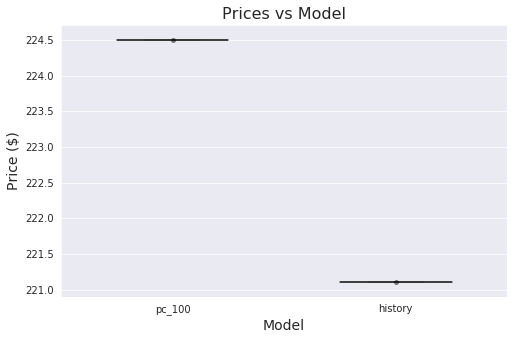

In [84]:

#############################################
#############################################
# 3. Prices (Box Plot)
#############################################
#############################################

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))

# make boxplot with Seaborn
bplot = sns.boxplot(
    data=prices_df_complete,
    width=0.5,
    palette="colorblind"
)

# add stripplot to boxplot with Seaborn
bplot = sns.stripplot(
    data=prices_df_complete,
    jitter=False,
    marker='o',
    alpha=0.5,
    color='black')

bplot.axes.set_title("Prices vs Model",
                     fontsize=16)

bplot.set_xlabel("Model",
                 fontsize=14)

bplot.set_ylabel("Price ($)",
                 fontsize=14)

bplot.tick_params(labelsize=10)

# output file name
plot_file_name = "./results/3_prices.png"

# save as jpeg
bplot.figure.savefig(plot_file_name,
                     format='png',
                     dpi=300)

In [85]:

print("Took: {}".format((time.time() - START_TIME)/60))

Took: 0.9340062022209168
